##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# tf.keras를 사용한 Neural Style Transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />TensorFlow.org에서 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />깃허브(GitHub) 소스 보기</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: 이 문서는 텐서플로 커뮤니티에서 번역했습니다. 커뮤니티 번역 활동의 특성상 정확한 번역과 최신 내용을 반영하기 위해 노력함에도
불구하고 [공식 영문 문서](https://www.tensorflow.org/?hl=en)의 내용과 일치하지 않을 수 있습니다.
이 번역에 개선할 부분이 있다면
[tensorflow/docs-l10n](https://github.com/tensorflow/docs-l10n/) 깃헙 저장소로 풀 리퀘스트를 보내주시기 바랍니다.
문서 번역이나 리뷰에 참여하려면
[docs-ko@tensorflow.org](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ko)로
메일을 보내주시기 바랍니다.

## 개요

이번 튜토리얼에서는 딥러닝을 사용하여 원하는 이미지를 다른 스타일의 이미지로 구성하는 법을 배워보겠습니다(피카소나 반 고흐처럼 그리기를 희망하나요?). 이 기법은 *Neural Style Transfer*로 알려져있으며, Leon A. Gatys의 논문 [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)에 잘 기술되어 있습니다.

참고: 본 튜토리얼은 처음에 발표된 기존의 스타일 전이 알고리즘을 소개합니다. 이 알고리즘은 이미지의 콘텐츠를 특정 스타일에 최적화시키는 방식으로 작동합니다. 보다 최근에 개발된 ([CycleGan](cyclegan.ipynb)과 같은) 알고리즘은 모델로 하여금 스타일이 변이된 이미지를 직접 생성하도록 만듭니다. 이 접근은 기존의 스타일 전이 알고리즘에 비해 훨씬 빠릅니다 (최대 1000배). [텐서플로 허브](https://tensorflow.org/hub)와 [텐서플로 라이트](https://www.tensorflow.org/lite/models/style_transfer/overview)에서는 이러한 [사전 훈련된 이미지 변이 모듈](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_arbitrary_image_stylization.ipynb)을 제공하고 있습니다.

Neural style transfer은 *콘텐츠 (content)* 이미지와 (유명한 작가의 삽화와 같은) *스타일 참조 (style reference)* 이미지를 이용하여, 콘텐츠 이미지의 콘텐츠는 유지하되  스타일 참조 이미지의 화풍으로 채색한 것 같은 새로운 이미지를 생성하는 최적화 기술입니다.

이 과정은 출력 이미지를 콘텐츠 이미지의 콘텐츠 통계랑(statistic)과 스타일 참조 이미지의 스타일 통계량에 맞춰 최적화시킴으로써 구현됩니다. 통계량은 합성곱 신경망을 이용해 각각의 이미지에서 추출합니다.

예시로, 아래에 주어진 강아지의 이미지와 바실리 칸딘스키의 7번 작품을 살펴봅시다:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[노란 래브라도](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), 출처: 위키미디아 공용

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


만약 칸딘스키가 7번 작품의 화풍으로 이 강아지를 그렸다면 어떤 작품이 탄생했을까요? 아마 이런 그림이 아니었을까요?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## 설정

### 모듈 구성 및 임포트

In [17]:
import tensorflow as tf

In [113]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [112]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

이미지를 다운로드받고 스타일 참조 이미지와 콘텐츠 이미지를 선택합니다:

In [158]:
content_path = tf.keras.utils.get_file('cotent1.jpg', 'https://www.dailyhindnews.com/wp-content/uploads/2020/09/1599089267_The-Best-Metroidvania-Games-Across-PC-Xbox-One-PS4-and.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = 'InYeol\텐서플로\GAN\497738_crazy-and-depressed-art-bizarre-art-by-strange-people_1211x1200_h.jpg'

## 입력 시각화

이미지를 불러오는 함수를 정의하고, 최대 이미지 크기를 512개의 픽셀로 제한합니다.

In [159]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

이미지를 출력하기 위한 간단한 함수를 정의합니다:

In [160]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [162]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 145: invalid start byte

## TF-Hub를 통한 빠른 스타일 전이

앞서 언급했듯이, 본 튜토리얼은 이미지 콘텐츠를 특정 스타일에 맞춰 최적화시키는 기존의 스타일 전이 알고리즘을 소개합니다. 이에 대해 살펴보기 전에, [텐서플로 허브](https://tensorflow.org/hub) 모듈은 어떤 결과물을 생성하는지 시험해봅시다:

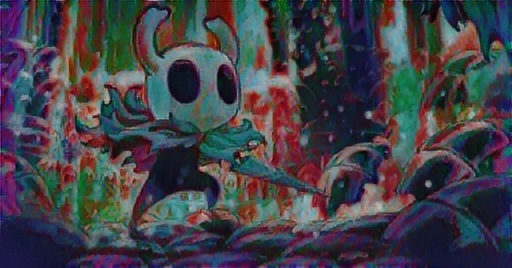

In [122]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## 콘텐츠와 스타일 표현 정의하기

이미지의 콘텐츠와 스타일 표현(representation)을 얻기 위해, 모델의 몇 가지 중간층들을 살펴볼 것입니다. 모델의 입력층부터 시작해서, 처음 몇 개의 층은 선분이나 질감과 같은 이미지 내의 저차원적 특성에 반응합니다. 반면, 네트워크가 깊어지면 최종 몇 개의 층은 *바퀴*나 *눈*과 같은 고차원적 특성들을 나타냅니다. 이번 경우, 우리는 사전학습된 이미지 분류 네트워크인 VGG19 네트워크의 구조를 사용할 것입니다. 이 중간층들은 이미지에서 콘텐츠와 스타일 표현을 정의하는 데 필요합니다. 입력 이미지가 주어졌을때, 스타일 전이 알고리즘은 이 중간층들에서 콘텐츠와 스타일에 해당하는 타깃 표현들을 일치시키려고 시도할 것입니다.


[VGG19](https://keras.io/applications/#vgg19) 모델을 불러오고, 작동 여부를 확인하기 위해 이미지에 적용시켜봅시다:

In [123]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [124]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('comic_book', 0.18927427),
 ('mask', 0.14320858),
 ('freight_car', 0.041835938),
 ('gasmask', 0.035845924),
 ('loudspeaker', 0.027210874)]

이제 분류층을 제외한 `VGG19` 모델을 불러오고, 각 층의 이름을 출력해봅니다.

In [125]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


이미지의 스타일과 콘텐츠를 나타내기 위한 모델의 중간층들을 선택합니다:


In [126]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### 스타일과 콘텐츠를 위한 중간층

그렇다면 사전훈련된 이미지 분류 네트워크 속에 있는 중간 출력으로 어떻게 스타일과 콘텐츠 표현을 정의할 수 있을까요?

고수준에서 보면 (네트워크의 훈련 목적인) 이미지 분류를 수행하기 위해서는 네트워크가 반드시 이미지를 이해햐야 합니다. 이는 미가공 이미지를 입력으로 받아 픽셀값들을 이미지 내에 존재하는 특성(feature)들에 대한 복합적인 이해로 변환할 수 있는 내부 표현(internal representation)을 만드는 작업이 포함됩니다.

또한 부분적으로 왜 합성곱(convolutional) 신경망의 일반화(generalize)가 쉽게 가능한지를 나타냅니다. 즉, 합성곱 신경망은 배경잡음(background noise)과 기타잡음(nuisances)에 상관없이 (고양이와 강아지와 같이)클래스 안에 있는 불변성(invariance)과 특징을 포착할 수 있습니다. 따라서 미가공 이미지의 입력과 분류 레이블(label)의 출력 중간 어딘가에서 모델은 복합 특성(complex feature) 추출기의 역할을 수행합니다. 그러므로, 모델의 중간층에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 추출할 수 있습니다.

## 모델 만들기 

`tf.keras.applications`에서 제공하는 모델들은 케라스 함수형 API을 통해 중간층에 쉽게 접근할 수 있도록 구성되어있습니다.

함수형 API를 이용해 모델을 정의하기 위해서는 모델의 입력과 출력을 지정합니다:

`model = Model(inputs, outputs)`

아래의 함수는 중간층들의 결과물을 배열 형태로 출력하는 `VGG19` 모델을 반환합니다:

In [127]:
def vgg_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

위 함수를 이용해 모델을 만들어봅시다:

In [128]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 364, 512, 64)
  최솟값:  0.0
  최댓값:  670.8537
  평균:  13.198646

block2_conv1
  크기:  (1, 182, 256, 128)
  최솟값:  0.0
  최댓값:  3914.1016
  평균:  89.67196

block3_conv1
  크기:  (1, 91, 128, 256)
  최솟값:  0.0
  최댓값:  7106.191
  평균:  114.01222

block4_conv1
  크기:  (1, 45, 64, 512)
  최솟값:  0.0
  최댓값:  11014.768
  평균:  358.2938

block5_conv1
  크기:  (1, 22, 32, 512)
  최솟값:  0.0
  최댓값:  1659.0422
  평균:  27.955965



## 스타일 계산하기

이미지의 콘텐츠는 중간층들의 특성 맵(feature map)의 값들로 표현됩니다.

이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명할 수 있습니다. 이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후,평균값을 냄으로써 구할 수 있습니다. 주어진 층에 대한 그람 행렬은 다음과 같이 계산할 수 있습니다:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

이 식은 `tf.linalg.einsum` 함수를 통해 쉽게 계산할 수 있습니다:

In [129]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 스타일과 콘텐츠 추출하기


스타일과 콘텐츠 텐서를 반환하는 모델을 만듭시다.

In [130]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

이미지가 입력으로 주어졌을때, 이 모델은 `style_layers`의 스타일과 `content_layers`의 콘텐츠에 대한 그람 행렬을 출력합니다:

In [131]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())


스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.009553759
    최댓값:  23109.547
    평균:  642.9447

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  129395.805
    평균:  22521.951

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  44.748913
    최댓값:  513898.38
    평균:  28771.758

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  7059131.5
    평균:  376027.97

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  146527.56
    평균:  3674.0586

콘텐츠:
   block5_conv2
    크기:  (1, 16, 32, 512)
    최솟값:  0.0
    최댓값:  1636.1411
    평균:  22.592718


## 경사하강법 실행

이제 스타일과 콘텐츠 추출기를 사용해 스타일 전이 알고리즘을 구현할 차례입니다. 타깃에 대한 입력 이미지의 평균 제곱 오차를 계산한 후, 오차값들의 가중합을 구합니다.

스타일과 콘텐츠의 타깃값을 지정합니다:

In [132]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

최적화시킬 이미지를 담을 `tf.Variable`을 정의하고 콘텐츠 이미지로 초기화합니다. (이때 `tf.Variable`는 콘텐츠 이미지와 크기가 같아야 합니다.):

In [134]:
image = tf.Variable(content_image)

픽셀 값이 실수이므로 0과 1 사이로 클리핑하는 함수를 정의합니다:

In [135]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

옵티마이저를 생성합니다. 참조 연구에서는 LBFGS를 추천하지만, `Adam`도 충분히 적합합니다:

In [136]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

최적화를 진행하기 위해, 전체 오차를 콘텐츠와 스타일 오차의 가중합으로 정의합니다:

In [137]:
style_weight=1e-2
content_weight=1e4

In [138]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

`tf.GradientTape`를 사용해 이미지를 업데이트합니다.

In [139]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

구현한 알고리즘을 시험해보기 위해 몇 단계를 돌려봅시다:

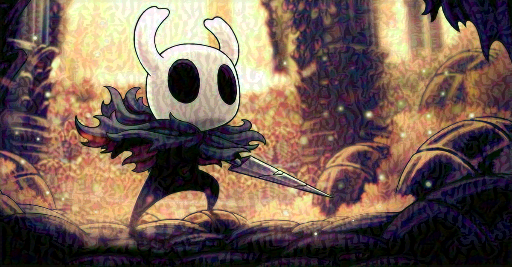

In [140]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

잘 작동하는 것을 확인했으니, 더 오랫동안 최적화를 진행해봅니다:

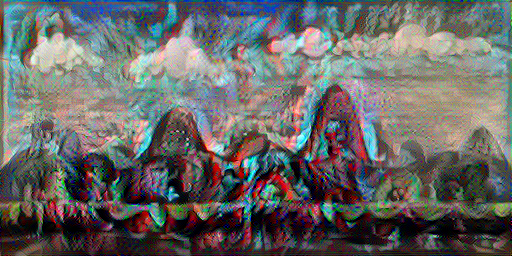

훈련 스텝: 1000
전체 소요 시간: 77.5


In [89]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))
  
end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

## 총 변위 손실

이 기본 구현 방식의 한 가지 단점은 많은 고주파 아티팩(high frequency artifact)가 생겨난다는 점 입니다. 아티팩 생성을 줄이기 위해서는 이미지의 고주파 구성 요소에 대한 레귤러리제이션(regularization) 항을 추가해야 합니다. 스타일 전이에서는 이 변형된 오차값을 *총 변위 손실(total variation loss)*라고 합니다:

In [141]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

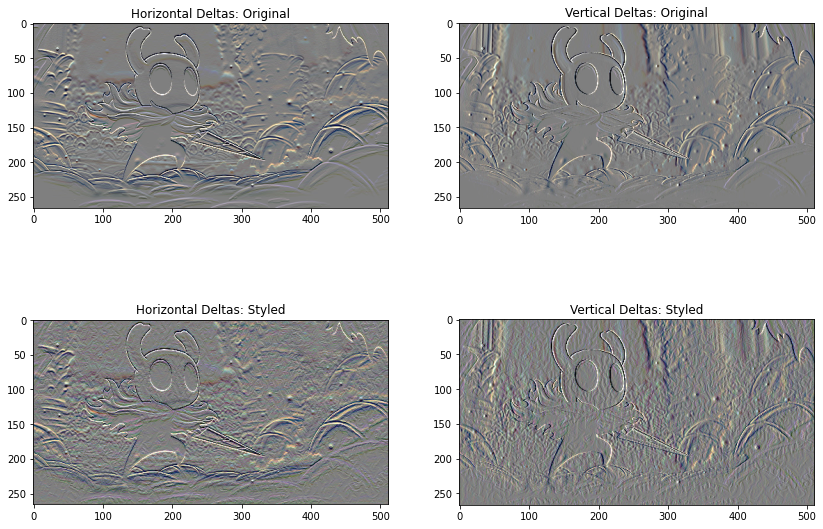

In [142]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

위 이미지들은 고주파 구성 요소가 늘어났다는 것을 보여줍니다.

한 가지 흥미로운 사실은 고주파 구성 요소가 경계선 탐지기의 일종이라는 점입니다. 이를테면 소벨 경계선 탐지기(Sobel edge detector)를 사용하면 유사한 출력을 얻을 수 있습니다:

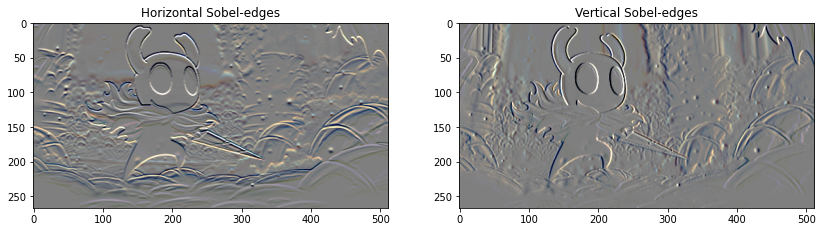

In [143]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

정규화 오차는 각 값의 절대값의 합으로 표현됩니다:

In [144]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [145]:
total_variation_loss(image).numpy()

35221.457

식이 잘 계산된다는 것을 확인할 수 있습니다. 하지만 다행히도 텐서플로에는 이미 표준 함수가 내장되어 있기 직접 오차식을 구현할 필요는 없습니다:

In [146]:
tf.image.total_variation(image).numpy()

array([35221.457], dtype=float32)

## 다시 최적화하기

`total_variation_loss`를 위한 가중치를 정의합니다:

In [148]:
total_variation_weight=30

이제 이 가중치를 `train_step` 함수에서 사용합니다:

In [149]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

최적화할 변수를 다시 초기화합니다:

In [150]:
image = tf.Variable(content_image)

최적화를 수행합니다:

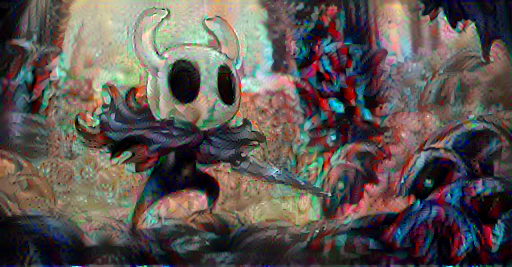

훈련 스텝: 750
전체 소요 시간: 62.1


In [151]:
import time
start = time.time()

epochs = 15
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

마지막으로, 결과물을 저장합니다:

In [152]:
file_name = 'stylized-image3.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)